In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from pathlib import Path
from tempfile import gettempdir

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.geometry import transform_points
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace

from src.utils import load_config, get_model_class
# from src.dataset import load_datasets
from src.trainer import Trainer

C:\Users\bosch\Desktop\Lilach_Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [2]:
# Configurations
CONFIG_PATH = "models/configs/baseline_res50_config.yaml"
MODEL_NAME = "BaselineRes50Model"  # name of model file in models/
EXP_NAME = "notebook_exp_baseline_res50"
CHECKPOINT_EPOCH = 154  # which epoch to load for evaluation/vis

# Load config
cfg = load_config(CONFIG_PATH)

In [3]:
# Paths
exp_dir = os.path.join("experiments", EXP_NAME)
os.makedirs(exp_dir, exist_ok=True)
ckpt_path = os.path.join(exp_dir, f"epoch_{CHECKPOINT_EPOCH}.pth")
pred_path = os.path.join(exp_dir, f"predictions_{CHECKPOINT_EPOCH}.csv")

In [4]:
# Load Datasets
# train_loader, val_loader = load_datasets(cfg)
# os.environ["L5KIT_DATA_FOLDER"] = "data/small_dataset"
os.environ["L5KIT_DATA_FOLDER"] = "../data/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=0)
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [5]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")

Number of training samples: 22496709
Number of training batches: 937363


In [ ]:
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=0)
print(eval_dataset)

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
# num_frames_to_chop = 100
# eval_cfg = cfg["val_data_loader"]
# zarr_path = Path(dm.require(eval_cfg["key"]))
# eval_base_path = zarr_path.parent / f"{zarr_path.stem}_chopped_{num_frames_to_chop}"

# if not eval_base_path.exists():
#     eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
#                               num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

# eval_zarr_path = str(Path(eval_base_path) / zarr_path.name)
# eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_gt_path = str(Path(eval_base_path) / "gt.csv")

# eval_zarr = ChunkedDataset(eval_zarr_path).open()
# eval_mask = np.load(eval_mask_path)["arr_0"]

# # ===== INIT DATASET AND LOAD MASK
# eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
# eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
#                             num_workers=0)
# print(eval_dataset)

C:\Users\bosch\Desktop\Lilach_Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\data\zarr_utils.py:244: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 16220/16220 [24:27<00:00, 11.05it/s]
C:\Users\bosch\Desktop\Lilach_Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\evaluation\extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 94694/94694 [13:42<00:00, 115.09it/s]
C:\Users\bosch\AppData\Local\Temp\ipykernel_6360\1837603617.py:19: RuntimeWarning: you're running with a custom agents_mask
  eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
# Create Model
ModelClass = get_model_class(MODEL_NAME)
model = ModelClass(cfg)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\bosch\miniconda3\envs\lilach_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bosch\miniconda3\envs\lilach_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda:0


In [8]:
print(model)
print(list(model.parameters()))
print(sum(p.numel() for p in model.parameters()))

BaselineRes50Model(
  (model): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [9]:
from src.trainer import Trainer
# Train (only if checkpoint doesn't exist)
losses_train = []
if not os.path.exists(ckpt_path):
    print(f"Checkpoint not found at {ckpt_path}, training model...")
    trainer = Trainer(cfg, model, device, train_dataloader, exp_name=EXP_NAME)
    # losses_train = trainer.train(CHECKPOINT_EPOCH)
    losses_train, losses_val = trainer.train_and_validate(eval_dataloader, CHECKPOINT_EPOCH)
else:
    print(f"Loading existing checkpoint: {ckpt_path}")
    model.load_state_dict(torch.load(ckpt_path))

Checkpoint not found at experiments\notebook_exp_baseline_res50\epoch_154.pth, training model...


loss: 75.69163513183594 loss(avg): 75.69163513183594:   2%|▏         | 1/50 [00:13<11:02, 13.51s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 106.69520568847656 loss(avg): 91.19342041015625:   4%|▍         | 2/50 [00:17<06:14,  7.80s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 102.8428955078125 loss(avg): 95.07657877604167:   6%|▌         | 3/50 [00:20<04:38,  5.92s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 77.8380126953125 loss(avg): 90.76693725585938:   8%|▊         | 4/50 [00:24<03:49,  5.00s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 210.7406768798828 loss(avg): 114.76168518066406:  10%|█         | 5/50 [00:28<03:23,  4.53s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 125.23326110839844 loss(avg): 116.50694783528645:  12%|█▏        | 6/50 [00:31<03:04,  4.19s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 190.95693969726562 loss(avg): 127.14266095842633:  14%|█▍        | 7/50 [00:35<02:51,  3.98s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 34.5652961730957 loss(avg): 115.57049036026001:  16%|█▌        | 8/50 [00:38<02:41,  3.85s/it]  

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 119.44276428222656 loss(avg): 116.00074301825629:  18%|█▊        | 9/50 [00:42<02:33,  3.73s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.502540588378906 loss(avg): 110.15092277526855:  20%|██        | 10/50 [00:46<02:27,  3.69s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.588138580322266 loss(avg): 105.37248784845525:  22%|██▏       | 11/50 [00:49<02:22,  3.65s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 82.26103210449219 loss(avg): 103.446533203125:  24%|██▍       | 12/50 [00:53<02:17,  3.61s/it]   

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 89.26038360595703 loss(avg): 102.35529092641977:  26%|██▌       | 13/50 [00:56<02:12,  3.59s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 75.31367492675781 loss(avg): 100.42374692644391:  28%|██▊       | 14/50 [01:00<02:08,  3.58s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 168.22344970703125 loss(avg): 104.9437271118164:  30%|███       | 15/50 [01:03<02:05,  3.57s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 56.7978515625 loss(avg): 101.93460988998413:  32%|███▏      | 16/50 [01:07<02:00,  3.53s/it]    

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.42147445678711 loss(avg): 99.3161901586196:  34%|███▍      | 17/50 [01:10<01:56,  3.54s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 112.54971313476562 loss(avg): 100.0513858795166:  36%|███▌      | 18/50 [01:14<01:51,  3.50s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 182.2002716064453 loss(avg): 104.3750114440918:  38%|███▊      | 19/50 [01:17<01:48,  3.50s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 54.77168273925781 loss(avg): 101.8948450088501:  40%|████      | 20/50 [01:21<01:44,  3.49s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 88.98291015625 loss(avg): 101.27999096825009:  42%|████▏     | 21/50 [01:24<01:41,  3.51s/it]  

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 97.81341552734375 loss(avg): 101.1224193572998:  44%|████▍     | 22/50 [01:28<01:38,  3.52s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 31.379838943481445 loss(avg): 98.09013325235118:  46%|████▌     | 23/50 [01:31<01:35,  3.52s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 30.671979904174805 loss(avg): 95.2810435295105:  48%|████▊     | 24/50 [01:35<01:32,  3.54s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.264923095703125 loss(avg): 93.7603987121582:  50%|█████     | 25/50 [01:39<01:31,  3.67s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 110.09534454345703 loss(avg): 94.38866585951585:  52%|█████▏    | 26/50 [01:43<01:29,  3.74s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 4.252682209014893 loss(avg): 91.05029609468248:  54%|█████▍    | 27/50 [01:46<01:25,  3.72s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 30.1036376953125 loss(avg): 88.87362972327641:  56%|█████▌    | 28/50 [01:50<01:22,  3.73s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 82.19102478027344 loss(avg): 88.64319507006941:  58%|█████▊    | 29/50 [01:54<01:18,  3.72s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.334415435791016 loss(avg): 87.59956908226013:  60%|██████    | 30/50 [01:57<01:14,  3.70s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 58.610809326171875 loss(avg): 86.66444779980567:  62%|██████▏   | 31/50 [02:01<01:10,  3.70s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 59.395286560058594 loss(avg): 85.81228651106358:  64%|██████▍   | 32/50 [02:05<01:06,  3.70s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 46.40707015991211 loss(avg): 84.61818904587717:  66%|██████▌   | 33/50 [02:09<01:03,  3.73s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 65.48381805419922 loss(avg): 84.05541342847488:  68%|██████▊   | 34/50 [02:13<01:00,  3.81s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 87.79134368896484 loss(avg): 84.1621542930603:  70%|███████   | 35/50 [02:17<00:57,  3.83s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 48.60942077636719 loss(avg): 83.17457836204105:  72%|███████▏  | 36/50 [02:20<00:54,  3.86s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 14.291346549987793 loss(avg): 81.31286939414773:  74%|███████▍  | 37/50 [02:24<00:50,  3.88s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 8.278396606445312 loss(avg): 79.39090958394502:  76%|███████▌  | 38/50 [02:28<00:46,  3.87s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 63.92010498046875 loss(avg): 78.99422228642:  78%|███████▊  | 39/50 [02:32<00:42,  3.84s/it]   

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 47.2617301940918 loss(avg): 78.20090998411179:  80%|████████  | 40/50 [02:36<00:37,  3.78s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 37.56327438354492 loss(avg): 77.20974814019552:  82%|████████▏ | 41/50 [02:39<00:33,  3.74s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 32.06106185913086 loss(avg): 76.1347794192178:  84%|████████▍ | 42/50 [02:43<00:30,  3.82s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 72.01566314697266 loss(avg): 76.03898601753767:  86%|████████▌ | 43/50 [02:47<00:26,  3.85s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 43.0180778503418 loss(avg): 75.28851083191958:  88%|████████▊ | 44/50 [02:51<00:22,  3.81s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 107.56180572509766 loss(avg): 76.00569516287909:  90%|█████████ | 45/50 [02:55<00:18,  3.77s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 41.71853256225586 loss(avg): 75.26032206286554:  92%|█████████▏| 46/50 [02:58<00:15,  3.75s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 57.14067840576172 loss(avg): 74.87479772973568:  94%|█████████▍| 47/50 [03:02<00:11,  3.79s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 61.9193115234375 loss(avg): 74.60489176710446:  96%|█████████▌| 48/50 [03:06<00:07,  3.85s/it] 

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 43.436744689941406 loss(avg): 73.96880713287665:  98%|█████████▊| 49/50 [03:10<00:03,  3.92s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


loss: 51.572975158691406 loss(avg): 73.52089049339294: 100%|██████████| 50/50 [03:14<00:00,  3.89s/it]

{'val_loss': 0.0, 'val_loss(avg)': 0.0}


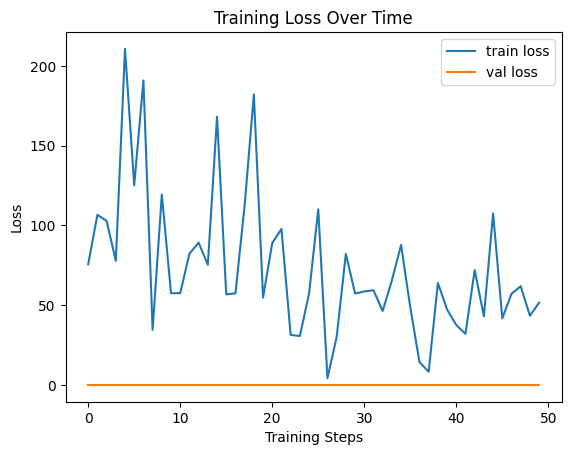

In [10]:
if losses_train:
    plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
    plt.plot(np.arange(len(losses_val)), losses_val, label="val loss")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.show()

In [11]:
# ===== GENERATE AND LOAD CHOPPED TEST DATASET
num_frames_to_chop = 100
test_cfg = cfg["test_data_loader"]
test_base_path = create_chopped_dataset(dm.require(test_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"],
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

C:\Users\bosch\Desktop\Lilach_Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\data\zarr_utils.py:244: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]
C:\Users\bosch\Desktop\Lilach_Project\LyftTrajectoryPrediction\l5kit\l5kit\l5kit\evaluation\extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:03<00:00, 143.95it/s]


In [12]:
test_zarr_path = str(Path(test_base_path) / Path(dm.require(test_cfg["key"])).name)
test_mask_path = str(Path(test_base_path) / "mask.npz")
test_gt_path = str(Path(test_base_path) / "gt.csv")

test_zarr = ChunkedDataset(test_zarr_path).open()
test_mask = np.load(test_mask_path)["arr_0"]
# ===== INIT TEST DATASET AND LOAD MASK
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset, shuffle=test_cfg["shuffle"], batch_size=test_cfg["batch_size"], 
                             num_workers=0)
print(test_dataset)

C:\Users\bosch\AppData\Local\Temp\ipykernel_6360\1746033959.py:8: RuntimeWarning: you're running with a custom agents_mask
  test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [19]:
# Evaluate
# ==== EVAL LOOP
def evaluate_model(model, test_dataloader, device, pred_path):
    model.eval()
    criterion = nn.MSELoss(reduction="none")

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    agent_ids = []

    progress_bar = tqdm(test_dataloader)
    with torch.no_grad():
        for data in progress_bar:
            loss, outputs = model.forward_pass(data, device, criterion)

            print(f"Loss: {loss.item():.4f}")

            # convert agent coordinates into world offsets
            agents_coords = outputs.cpu().numpy()
            world_from_agents = data["world_from_agent"].numpy()
            centroids = data["centroid"].numpy()
            coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
            
            future_coords_offsets_pd.append(np.stack(coords_offset))
            timestamps.append(data["timestamp"].numpy().copy())
            agent_ids.append(data["track_id"].numpy().copy())
    
    write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [20]:
# Evaluation (only if prediction doesn't exist)
if not os.path.exists(pred_path):
    print(f"Predictions not found at {pred_path}, evaluating model...")
    evaluate_model(model, test_dataloader, device, pred_path)
else:
    print(f"Loading existing predictions: {pred_path}")

Predictions not found at experiments\notebook_exp_baseline_res50\predictions_154.csv, evaluating model...


  5%|▌         | 1/20 [00:01<00:25,  1.36s/it]

Loss: 0.0000


 10%|█         | 2/20 [00:02<00:22,  1.27s/it]

Loss: 0.0000


 15%|█▌        | 3/20 [00:03<00:21,  1.25s/it]

Loss: 0.0000


 20%|██        | 4/20 [00:05<00:19,  1.24s/it]

Loss: 0.0000


 25%|██▌       | 5/20 [00:06<00:18,  1.21s/it]

Loss: 0.0000


 30%|███       | 6/20 [00:07<00:16,  1.21s/it]

Loss: 0.0000


 35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

Loss: 0.0000


 40%|████      | 8/20 [00:09<00:14,  1.20s/it]

Loss: 0.0000


 45%|████▌     | 9/20 [00:10<00:13,  1.19s/it]

Loss: 0.0000


 50%|█████     | 10/20 [00:12<00:11,  1.18s/it]

Loss: 0.0000


 55%|█████▌    | 11/20 [00:13<00:10,  1.22s/it]

Loss: 0.0000


 60%|██████    | 12/20 [00:14<00:09,  1.23s/it]

Loss: 0.0000


 65%|██████▌   | 13/20 [00:15<00:08,  1.21s/it]

Loss: 0.0000


 70%|███████   | 14/20 [00:17<00:07,  1.21s/it]

Loss: 0.0000


 75%|███████▌  | 15/20 [00:18<00:05,  1.19s/it]

Loss: 0.0000


 80%|████████  | 16/20 [00:19<00:04,  1.22s/it]

Loss: 0.0000


 85%|████████▌ | 17/20 [00:20<00:03,  1.20s/it]

Loss: 0.0000


 90%|█████████ | 18/20 [00:21<00:02,  1.18s/it]

Loss: 0.0000


 95%|█████████▌| 19/20 [00:22<00:01,  1.15s/it]

Loss: 0.0000


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Loss: 0.0000


100%|██████████| 480/480 [00:00<00:00, 2287.22it/s]


In [15]:
metrics = compute_metrics_csv(test_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

100%|██████████| 480/480 [00:00<00:00, 2891.15it/s]

neg_multi_log_likelihood 4937.663403504494
time_displace [ 0.23530736  0.43747738  0.64411225  0.8519582   1.11500977  1.32656754
  1.50185212  1.79834135  1.98526836  2.33355686  2.54243003  2.75562625
  3.13919748  3.38771579  3.70190105  4.07057682  4.34854109  4.77198345
  4.94903436  5.13711616  5.45227222  5.91581269  6.06695382  6.32134524
  6.67924804  7.06068021  7.32142519  7.57720183  7.81001064  8.13857417
  8.36041866  8.5337115   8.88763247  9.12966982  9.46324916  9.85627666
  9.90377934 10.2398031  10.43885837 10.62731511 11.01630051 11.22573954
 11.42577068 11.52834209 11.63311216 11.44694056 11.86592488 11.91750804
 11.95565624 12.25698143]


In [ ]:
# model.eval()
# torch.set_grad_enabled(False)

# # build a dict to retrieve future trajectories from GT
# gt_rows = {}
# for row in read_gt_csv(eval_gt_path):
#     gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

# eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

# for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
#     agent_indices = eval_dataset.get_frame_indices(frame_number) 
#     if not len(agent_indices):
#         continue

#     # get AV point-of-view frame
#     data_ego = eval_ego_dataset[frame_number]
#     im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
#     center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
#     predicted_positions = []
#     target_positions = []

#     for v_index in agent_indices:
#         print(f"Processing agent {v_index} in frame {frame_number}")
#         data_agent = eval_dataset[v_index]

#         out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
#         out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
#         # store absolute world coordinates
#         predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
#         # retrieve target positions from the GT and store as absolute coordinates
#         track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
#         target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


#     # convert coordinates to AV point-of-view so we can draw them
#     predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
#     target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

#     draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
#     draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

#     plt.imshow(im_ego)
#     plt.show()

In [17]:
# # Visualization (single example)
# batch = next(iter(eval_dataloader))
# with torch.no_grad():
#     preds = model(batch["image"])

# # Pick first mode of predictions
# preds = preds[:, 0, :].view(-1, cfg["model_params"]["future_num_frames"], 2).cpu().numpy()
# gt = batch["target_positions"].cpu().numpy()

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(batch["image"][0].permute(1, 2, 0).cpu().numpy())
# draw_trajectory(gt[0], ax, color="g", origin=(0, 0))  # Ground truth
# draw_trajectory(preds[0], ax, color="r", origin=(0, 0))  # Prediction
# ax.set_title("Green = GT, Red = Prediction")
# plt.show()

In [18]:
# batch = next(iter(val_loader))
# preds = model(batch["image"])
# preds = preds[:, 0, :].view(-1, cfg["model_params"]["future_num_frames"], 2).detach().numpy()

# fig, ax = plt.subplots(figsize=(8, 8))
# img = batch["image"][0].permute(1, 2, 0).numpy()
# ax.imshow(img)

# # Draw predicted trajectory (red) & ground truth (green)
# draw_trajectory(preds[0], ax, color="r", origin=(0, 0))
# draw_trajectory(batch["target_positions"][0].numpy(), ax, color="g", origin=(0, 0))
# plt.show()